<a href="https://colab.research.google.com/github/notanumber-sys/dd2365-project/blob/feat-conservation/project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Surface Waves in Steady State Shallow Flow by Navier-Stokes Equations**
**Ludwig Karlsson**, based on template by **Johan Hoffman**.

# **Set up environment**

In [30]:
# Load neccessary modules.
from google.colab import files

import numpy as np
import time

# Install FEniCS (this may take a long time)
try:
    import dolfin
except ImportError:
    !wget "https://fem-on-colab.github.io/releases/fenics-install.sh" -O "/tmp/fenics-install.sh" && bash "/tmp/fenics-install.sh"
    import dolfin
    
from dolfin import *; from mshr import *

import dolfin.common.plotting as fenicsplot

from matplotlib import pyplot as plt

# **Introduction**

The Navier-Stokes equations take the form

$\dot u + (u\cdot \nabla)u + \nabla p -\Delta u = f,\quad \nabla \cdot u=0,$

together with suitable initial and boundary conditions.

Here we present a FEniCS implementation of a stabilized space-time Arbitrary Lagrangian-Eulerian (ALE) finite element method to solve the Navier-Stokes equations in 2D. The solution is visualized using FEniCS plotting functions, and is also exported as pvd-files which can be visualized in Paraview.

We seek a finite element approximation $(u,p)\in V\times Q$ such that 

$(\dot u + ((u-m)\cdot \nabla)u, v) - (p,\nabla \cdot v) + (\nu \nabla u,\nabla v) + (\nabla \cdot u, q) + SD(u,p;v,q) = (f,v),$

for all test functions $(v,q) \in \hat V\times \hat Q$, where $SD(u,p;v,q)$ is a residual based stabilization term. The mesh velocity is denoted by m. 

We present an example of flow past a circular cylinder, for which we compute the force on the surface of the cylinder $\Gamma$ in the direction $\phi$, by Green's formula: 

$
F(u,p,\phi)= ~<\nu \nabla u\cdot n-pn, \Phi>_{\Gamma} ~=~(\dot u+(u\cdot \nabla)u, \Phi) + (\nu \nabla u,\nabla \Phi) - (p,\nabla \cdot\Phi)-(f,\Phi),
$

with $\Phi\in V$ a fuinction for which $\Phi\vert _{\Gamma}=\phi$ and $\Phi\vert_{\partial \Omega \setminus \Gamma}=0$. With $\phi=(1,0)$ we get the drag force $F_D$, and with $\phi=(0,1)$ the lift force $F_L$. The drag and lift coefficients are obtained by normalization, 

$
c_D = \frac{2F_D}{\rho U^2D}, \quad c_L = \frac{2F_L}{\rho U^2D}
$

where $\rho$ is the density (here $\rho=1$), $U$ the characteristic velocity (here $U=1$), and $D$ the characteristic length scale (here $D$ is the diameter of the cylinder). 

The Reynolds number is defined as $Re=\frac{UD}{\nu}$

To read more about how to use similar methods for more complex problems, see e.g. 

[Hoffman, Johan, et al. "Towards a parameter-free method for high reynolds number turbulent flow simulation based on adaptive finite element approximation." Computer Methods in Applied Mechanics and Engineering 288 (2015): 60-74.](https://www.sciencedirect.com/science/article/pii/S0045782514004836)


# **Method**

**Define domain and mesh**

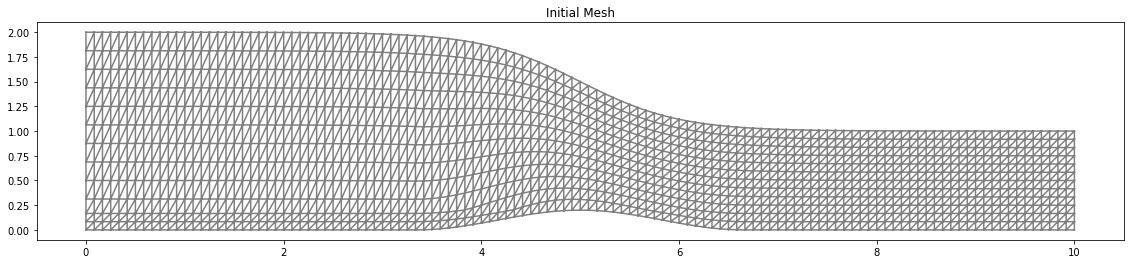

In [31]:
# Define rectangular domain 
L = 10
H = 1
H_min = 0.5 # used to limit outflow geometry deformation

# Define bump
B0 = H/5
r = L/6
bottom_shape = Expression("B0*pow(cos(pi*(x[0] - L/2)/(2*r)), 2.0)*(abs(x[0] - L/2) < r)", B0=B0, L=L, r=r, degree=2)
shape_displacement = Expression(("0", "(B0*pow(cos(pi*(x[0] - L/2)/(2*r)), 2.0)*(abs(x[0] - L/2) < r))*((H - x[1])/H)"), B0=B0, L=L, r=r, H=H, degree=2)

# Define initial wave shape (for debugging cases)
wave_epsilon = H/2
wave_width = L/10
#wave_shape = Expression("H + weps*exp(-pow(x[0] - L/2, 2)/(ww*ww))", H=H, weps=wave_epsilon, L=L, ww=wave_width, degree=2)
#wave_shape = Expression("H", H=H, degree=2)
wave_shape = Expression("H + 1/(1 + exp(2*(x[0] - 5)))", H=H, degree=2)
# slightly hacky displacement to leave bottom untouched
effective_height = H - B0
#wave_shape_displacement = Expression(("0", "(weps*exp(-pow(x[0] - L/2, 2)/(ww*ww)))*(x[1] > (H - EH))*((x[1] - H + EH)/EH)"), H=H, weps=wave_epsilon, L=L, ww=wave_width, EH=effective_height, degree=2)
wave_shape_displacement = Expression(("0", "(1/(1 + exp(2*(x[0] - 5))))*(x[1] > (H - EH))*((x[1] - H + EH)/EH)"), H=H, weps=wave_epsilon, L=L, ww=wave_width, EH=effective_height, degree=2)

# Define subdomains (for boundary conditions)
class Left(SubDomain):
    def inside(self, x, on_boundary):
        return near(x[0], 0.0) 

class Right(SubDomain):
    def inside(self, x, on_boundary):
        return near(x[0], L)

class Lower(SubDomain):
    def inside(self, x, on_boundary):
        #return near(x[1], 0)
        #return near(x[1], bottom_shape(x))
        if on_boundary and (not near(x[0], 0.0)) and (not near(x[0], L)) and x[1] <= 1.1*B0:
            return True
        if near(x[1], 0.0) and (near(x[0], 0.0) or near(x[0], L)):
            return True
        return False

# todo: change depending on initial wave shape
class Upper(SubDomain):
    def inside(self, x, on_boundary):
        return near(x[1], wave_shape(x))
      
left = Left()
right = Right()
lower = Lower()
upper = Upper()

# Generate mesh
resolution = 12
delta_x = 1/resolution
mesh = RectangleMesh(Point(0.0, 0.0), Point(L, H), L*resolution, H*resolution)

ALE.move(mesh, shape_displacement)
# displace for initial wave shape
ALE.move(mesh, wave_shape_displacement)

# Define mesh functions (for boundary conditions)
boundaries = MeshFunction("size_t", mesh, mesh.topology().dim()-1)
boundaries.set_all(0)
left.mark(boundaries, 1)
right.mark(boundaries, 2)
lower.mark(boundaries, 3)
upper.mark(boundaries, 4)

#meshfile = File("mesh/subdomains.pvd")
#meshfile << boundaries
#!tar -czvf meshfile.tar.gz mesh/subdomains.pvd
#files.download('meshfile.tar.gz')

plt.figure(figsize=(40, 4))
plot(mesh, title="Initial Mesh")
plt.show()

**Define finite element approximation spaces**

In [32]:
# Generate finite element spaces (for velocity and pressure)
V = VectorFunctionSpace(mesh, "Lagrange", 1)
Q = FunctionSpace(mesh, "Lagrange", 1)

# Define trial and test functions 
u = TrialFunction(V)
p = TrialFunction(Q)
v = TestFunction(V)
q = TestFunction(Q)

**Define boundary conditions**

In [33]:
# Define boundary conditions 
class DirichletBoundaryLower(SubDomain):
    def inside(self, x, on_boundary):
        # the domain definition seems to be working
        #return on_boundary and near(x[1], 0)
        #if on_boundary and (not near(x[0], 0.0)) and (not near(x[0], L)) and x[1] <= 0.11:
            #print("On lower boundary: ", x)
        if on_boundary and (not near(x[0], 0.0)) and (not near(x[0], L)) and x[1] <= 1.1*B0:
            return True
        if near(x[1], 0.0) and (near(x[0], 0.0) or near(x[0], L)):
            return True
        return False

class DirichletBoundaryUpper(SubDomain):
    def inside(self, x, on_boundary):
        #if on_boundary and (not near(x[0], 0.0)) and (not near(x[0], L)) and x[1] > 0.11:
            #print("On upper boundary: ", x)
        return on_boundary and (not near(x[0], 0.0)) and (not near(x[0], L)) and x[1] > 1.1*B0

class DirichletBoundaryLeft(SubDomain):
    def inside(self, x, on_boundary):
        return on_boundary and near(x[0], 0.0) 

class DirichletBoundaryRight(SubDomain):
    def inside(self, x, on_boundary):
        return on_boundary and near(x[0], L)

dbc_lower = DirichletBoundaryLower()
dbc_upper = DirichletBoundaryUpper()
dbc_left = DirichletBoundaryLeft()
dbc_right = DirichletBoundaryRight()

# Examples of time dependent and stationary inflow conditions
#uin = Expression('4.0*x[1]*(1-x[1])', element = V.sub(0).ufl_element())
#uin = Expression('1.0 + 1.0*fabs(sin(t))', element = V.sub(0).ufl_element(), t=0.0)
#uin = 1.0
#bcu_in0 = DirichletBC(V.sub(0), uin, dbc_left)
#bcu_in1 = DirichletBC(V.sub(1), 0.0, dbc_left)
#bcu_upp0 = DirichletBC(V.sub(0), 0.0, dbc_upper)
#bcu_upp1 = DirichletBC(V.sub(1), 0.0, dbc_upper)
#bcu_low0 = DirichletBC(V.sub(0), 0.0, dbc_lower)
#bcu_low1 = DirichletBC(V.sub(1), 0.0, dbc_lower)
#bcu_obj0 = DirichletBC(V.sub(0), 0.0, dbc_objects)
#bcu_obj1 = DirichletBC(V.sub(1), 0.0, dbc_objects)

#pin = Expression('5.0*fabs(sin(t))', element = Q.ufl_element(), t=0.0)
#pout = 0.0
#bcp0 = DirichletBC(Q, pin, dbc_left) 
#bcp1 = DirichletBC(Q, pout, dbc_right)

#bcu = [bcu_in0, bcu_in1, bcu_upp0, bcu_upp1, bcu_low0, bcu_low1, bcu_obj0, bcu_obj1]
#bcu = [bcu_in0, bcu_in1, bcu_upp1, bcu_low1, bcu_obj0, bcu_obj1]
#bcp = [bcp1]

# Define measure for boundary integration  
#ds = Measure('ds', domain=mesh, subdomain_data=boundaries)

# in flow
U = 3
Vdot = wave_shape(0.0)*U

#uin = Expression("U*x[1]*(2*H-x[1])/(H*H)", U=U, H=H, degree=2)
class InVelocityExpressionGrad(UserExpression):
    def eval(self, value, x):
        K = 3*Vdot/(2*self.h)
        y = x[1]
        value[0] = K*y*(2*self.h - y)/(self.h*self.h)

    def value_shape(self):
        return ()

class InVelocityExpression(UserExpression):
    def eval(self, value, x):
        K = Vdot/self.h
        value[0] = K

    def value_shape(self):
        return ()
uin = InVelocityExpression()
uin.h = wave_shape(0.0)

# out pressure
#pout = Expression("(xmax - x[1])*rho*g", xmax=H, rho=0.0, g=0.0, degree=2)
class OutPressureExpression(UserExpression):
    def eval(self, value, x):
        #print("pout(" + str(x) + ") = " + str((self.xmax - x[1])*self.rho*self.g))
        value[0] = (self.h - x[1])*self.g

    def value_shape(self):
        return ()

use_velocity_limits = True
max_velocity = 2*U
min_velocity = 1.5*U
class OutVelocityExpression(UserExpression):
    def eval(self, value, x):
        K = Vdot/self.h

        if use_velocity_limits:
            if K < min_velocity:
                K = min_velocity
            elif K > max_velocity:
                K = max_velocity
        value[0] = K

    def value_shape(self):
        return ()
#pout = OutPressureExpression()
#pout.h = H
uout = OutVelocityExpression()
uout.h = H

closed = False

if closed:
    bcu_left0 = DirichletBC(V.sub(0), 0.0, dbc_left)
    #bcu_left1 = DirichletBC(V.sub(1), 0.0, dbc_left)
    bcu_right0 = DirichletBC(V.sub(0), 0.0, dbc_right)
    #bcu_right1 = DirichletBC(V.sub(1), 0.0, dbc_right)
    bcu_low0 = DirichletBC(V.sub(0), 0.0, dbc_lower)
    bcu_low1 = DirichletBC(V.sub(1), 0.0, dbc_lower)

    bcp0 = DirichletBC(Q, 0.0, dbc_upper)
    
    bcu = [bcu_left0, bcu_right0, bcu_low0, bcu_low1]
    bcp = [bcp0]
else:
    bcu_left0 = DirichletBC(V.sub(0), uin, dbc_left)
    #bcu_left1 = DirichletBC(V.sub(1), 0.0, dbc_left)
    bcu_right0 = DirichletBC(V.sub(0), uout, dbc_right)
    #bcu_right1 = DirichletBC(V.sub(1), 0.0, dbc_right)
    bcu_low0 = DirichletBC(V.sub(0), 0.0, dbc_lower)
    bcu_low1 = DirichletBC(V.sub(1), 0.0, dbc_lower)

    bcp0 = DirichletBC(Q, 0.0, dbc_upper)
    #bcp_right = DirichletBC(Q, pout, dbc_right)

    #bcu = [bcu_left0, bcu_left1, bcu_right0, bcu_right1, bcu_low0, bcu_low1]
    bcu = [bcu_left0, bcu_right0, bcu_low0, bcu_low1]
    bcp = [bcp0]

# save mesh functions for inspection
#file = File("mesh/subdomains.pvd")
#file << boundaries
#!tar -czvf subdomains.tar.gz mesh/subdomains.pvd
#files.download('subdomains.tar.gz')

# **Results**

**Define flow parameters**

In [34]:
# Set viscosity
#nu = 4.0e-1
nu = 1.0e-6 # m²/s
rho = 1e3   # kg/m³

# set gravity
g = 9.81    # m/s²
f = Expression(("0", "-g"), g=g, degree=2);

#pout.rho = rho
#pout.g = g

**Initial Conditions**

In [35]:
class InitialPressureExpression(UserExpression):
  def eval(self, value, x):
    value[0] = (wave_shape(x) - x[1])*g*rho

  def value_shape(self):
    return ()

class InitialVelocityExpression(UserExpression):
  def eval(self, value, x):
    value[0] = uin(x[0], x[1])/wave_shape(x[0])
    value[1] = 0.0

  def value_shape(self):
    return (2,)

u_init = InitialVelocityExpression()
p_init = InitialPressureExpression()

**Define method parameters**

In [36]:
# Define iteration functions
# (u0,p0) solution from previous time step
# (u1,p1) linearized solution at present time step  
u0 = Function(V)
u1 = Function(V)
p0 = Function(Q)
p1 = Function(Q)

# initial conditions


# Define mesh deformation w, mesh velocity = w/dt
#amp_x = 0.0
#amp_y = 1.0e-2
#freq = 0.1
#t = 0.0
#w = Expression(("amp_x*sin(2.0*pi*t*freq)*sin(pi*x[0]/L)","amp_y*sin(2.0*pi*t*freq-0.5*pi)*sin(pi*x[1]/H)"), L=L, H=H, t=t, amp_x=amp_x, amp_y=amp_y, freq=freq, element = V.ufl_element())

class DisplacementExpression(UserExpression):
    def set_md(self, displacement):
        if displacement == None:
            self.mesh_displacement = None
        else:
            self.mesh_displacement = interpolate(displacement, V)
            self.mesh_displacement.set_allow_extrapolation(True)
    
    def eval(self, value, x):
        if self.mesh_displacement is None:
            value[0] = 0.0
            value[1] = 0.0
        else:
            result = self.mesh_displacement(x[0], x[1])
            value[0] = result[0]
            value[1] = result[1]

    def value_shape(self):
        return (2,)
w = DisplacementExpression()
w.set_md(None)

# Set parameters for nonlinear and lienar solvers 
num_nnlin_iter = 5 
prec = "amg" if has_krylov_solver_preconditioner("amg") else "default" 

# Time step length
#dt = 0.5*mesh.hmin() /(10*U)
dt = 0.5*mesh.hmin() /30

**Define variational problem**

In [37]:
# Define variational problem

# Stabilization parameters
h = CellDiameter(mesh);
u_mag = sqrt(dot(u1,u1))
d1 = 1.0/sqrt((pow(1.0/dt,2.0) + pow(u_mag/h,2.0)))
d2 = h*u_mag

# Mean velocities for trapozoidal time stepping
um = 0.5*(u + u0)
um1 = 0.5*(u1 + u0)

# Momentum variational equation on residual form
Fu = inner((u - u0)/dt + grad(um)*(um1-w/dt), v)*dx \
    - p1*div(v)*dx \
    + nu*inner(grad(um), grad(v))*dx \
    + d1*inner((u - u0)/dt + grad(um)*(um1-w/dt) + (1/rho)*grad(p1), grad(v)*(um1-w/dt))*dx \
    + d2*div(um)*div(v)*dx \
    - inner(f, v)*dx
au = lhs(Fu)
Lu = rhs(Fu)

# Continuity variational equation on residual form
Fp = d1*inner((u1 - u0)/dt + grad(um1)*(um1-w/dt) + grad(p), grad(q))*dx + div(um1)*q*dx 
ap = lhs(Fp)
Lp = rhs(Fp)

**Set plotting variables and open export files**

In [38]:
# Open files to export solution to Paraview
file_u = File("results-NS/u.pvd")
file_p = File("results-NS/p.pvd")

# Set plot frequency
plot_time = 0
plot_freq = 20

# Time data 
time = np.array(0.0)
time = np.delete(time, 0)
start_sample_time = 1.0

**Time stepping algorithm**

rm: cannot remove 'results-NS/*': No such file or directory
Initial Pressure
Initial Velocity
Time t = 0.0025445356988236766
1.9999542250408096 1.9999467805167273 1.999937129218592 1.999925727807146 1.9999122589709817 1.9998963478955745 1.9998775518430703 1.9998553478547147 1.9998291182313066 1.9997981333919808 1.9997615316404398 1.9997182952841577 1.99966722245405 1.9996068938572724 1.999535633561565 1.9994514627528486 1.9993520452253981 1.9992346231521179 1.9990959414374974 1.9989321586736029 1.998738742396121 1.99851034596935 1.9982406640134132 1.9979222628225832 1.9975463817118106 1.9971027006746187 1.9965790691509122 1.995961190108325 1.9952322530687325 1.9943725092141045 1.993358781359747 1.9921639014997923 1.9907560689673032 1.9890981232285063 1.9871467272444923 1.984851460578719 1.9821538265160397 1.9789861850320565 1.9752706342903326 1.9709178783484387 1.965826138882227 1.9598801948894697 1.952950667122619 1.9448937033922795 1.9355512656548537 1.9247522667923629 1.912314848192

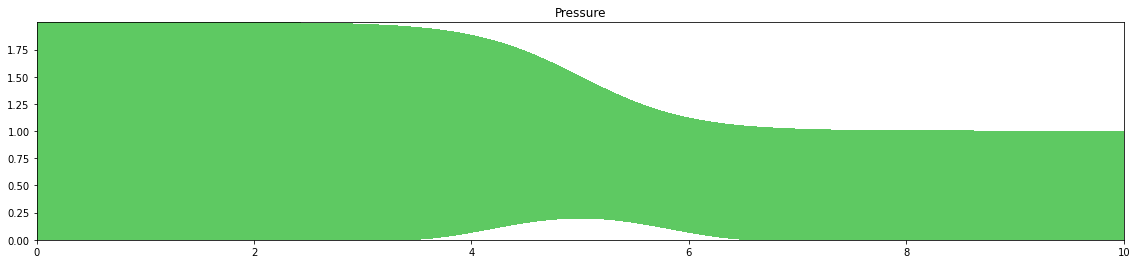

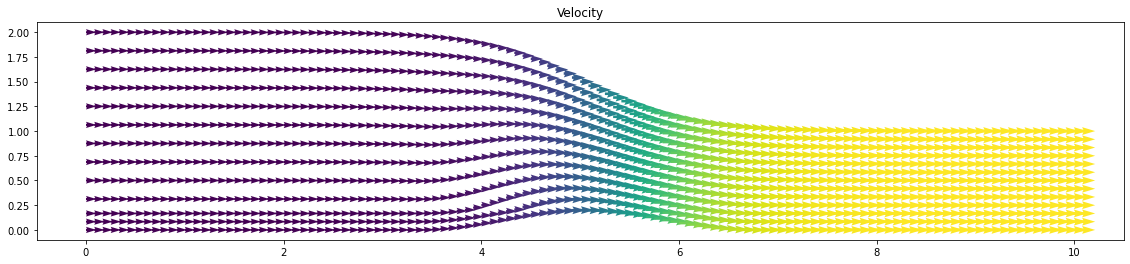

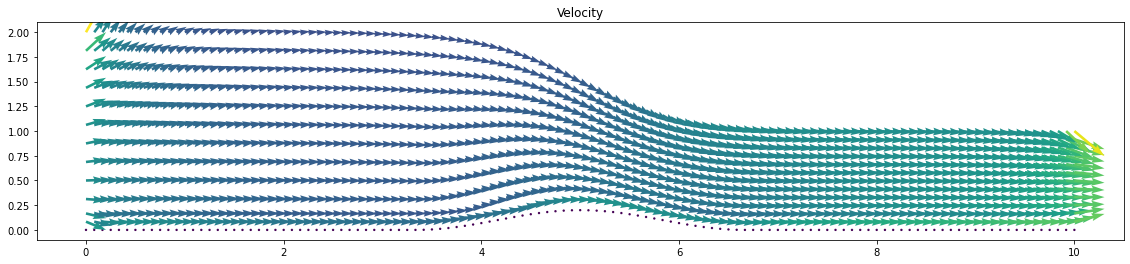

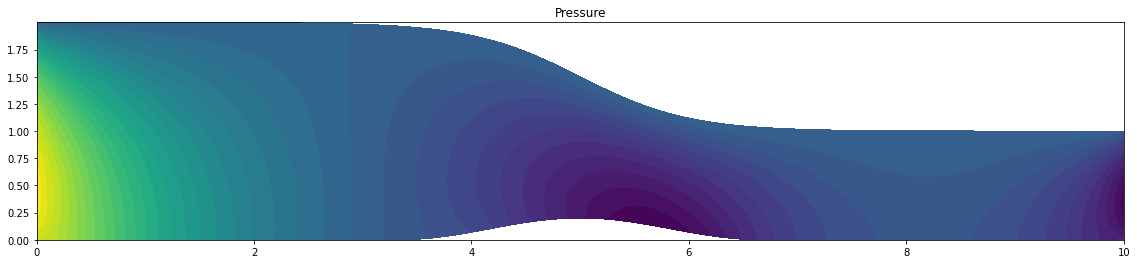

New Mesh:
Time t = 0.005089071397647353
2.0134166766100194 2.005740930058719 2.005940930850819 2.0047683352386905 2.004208698400933 2.0036765325188313 2.0032567894966187 2.002893463386104 2.002576564680749 2.002292415536501 2.002032769356432 2.00179084390593 2.001561252531062 2.001339351385356 2.001120950437091 2.000902064614265 2.0006787299476114 2.00044684776721 2.0002020451289804 1.9999395391856911 1.9996539968401634 1.999339384334933 1.9989888030913483 1.99859430589649 1.998146687096179 1.9976352410432074 1.9970474837341974 1.9963688324441182 1.995582235677983 1.9946677459358064 1.993602029118671 1.9923578033118667 1.990903198956219 1.989201033375904 1.9872079962142823 1.98487425787238 1.9821418507068125 1.9789432462981846 1.975201209084875 1.9708261631303892 1.9657166975335105 1.959757920773691 1.9528207034751879 1.9447613843004807 1.9354220101609407 1.9246313862791005 1.9122072989786834 1.8979602183814506 1.881698807675879 1.8632375293686798 1.8424118630610997 1.819080187382371 1

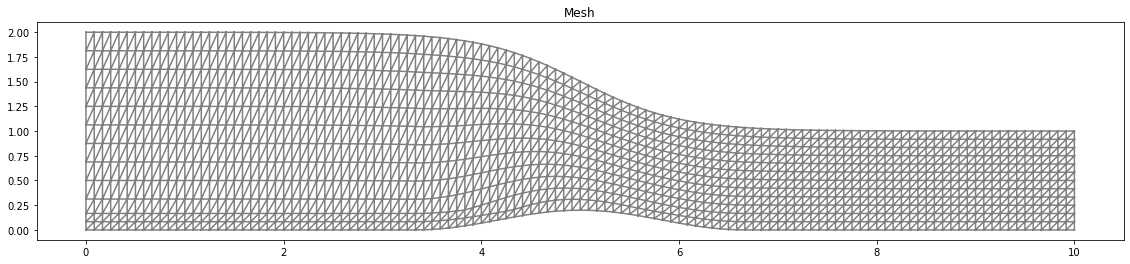

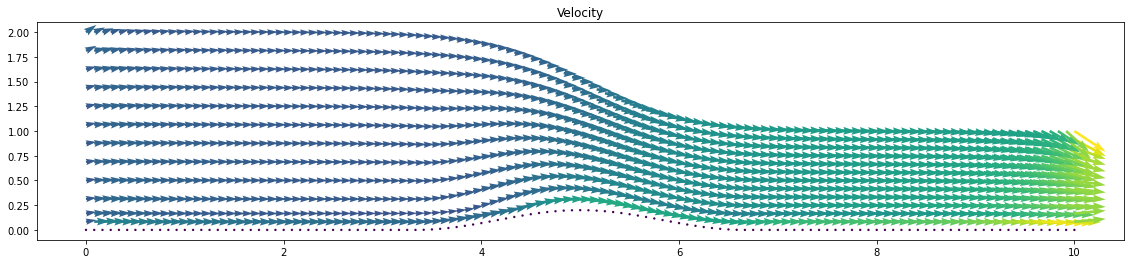

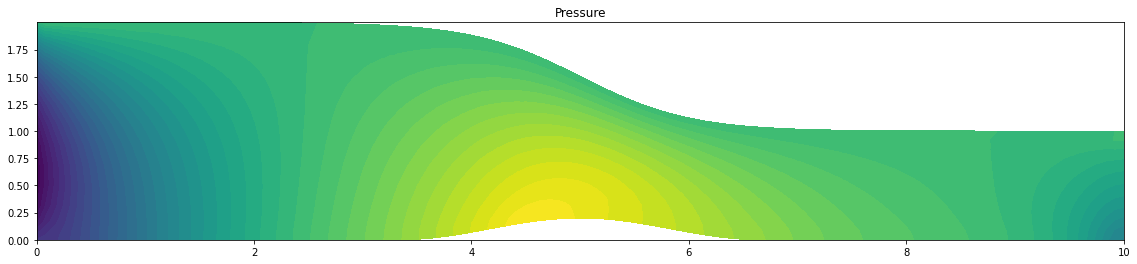

New Mesh:
Time t = 0.00763360709647103
2.0157318565123794 2.007674432352005 2.0075165448012244 2.006026080850192 2.005254681512819 2.0045862248421433 2.004055829460777 2.003608815415675 2.0032223306160715 2.0028798897792024 2.002569856536489 2.002283780432412 2.0020150011753555 2.0017580323368915 2.001508062889303 2.0012606482658386 2.0010114720298278 2.000756159920239 2.0004901199067486 2.0002083930390517 1.9999055045225393 1.999575307652947 1.9992108155033834 1.9988040143901808 1.9983456525386183 1.9978249981943281 1.9972295617728795 1.9965447762490702 1.9957536288197184 1.9948362362417384 1.9937693575854512 1.9925258368452123 1.9910739679617495 1.9893767758277 1.987391197558805 1.985067712824063 1.982348755253299 1.9791672649593393 1.975446577221754 1.9710977896854744 1.9660202526975223 1.960099987996979 1.9532089903792824 1.9452048602958376 1.9359309676092677 1.925217522671374 1.9128837438503055 1.898741472099742 1.8826005495654254 1.8642761325027206 1.8436038764698957 1.8204416850

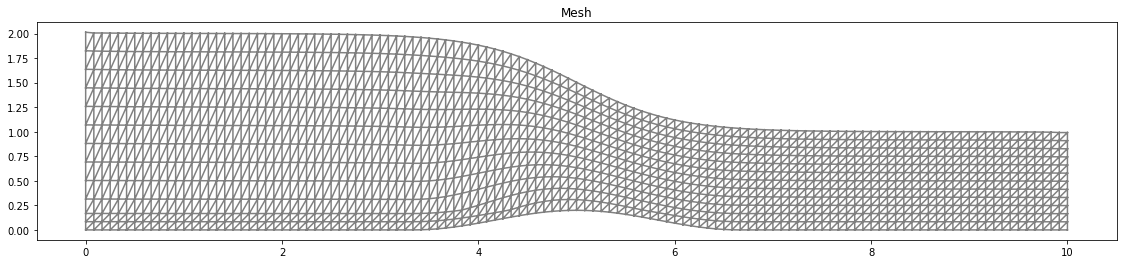

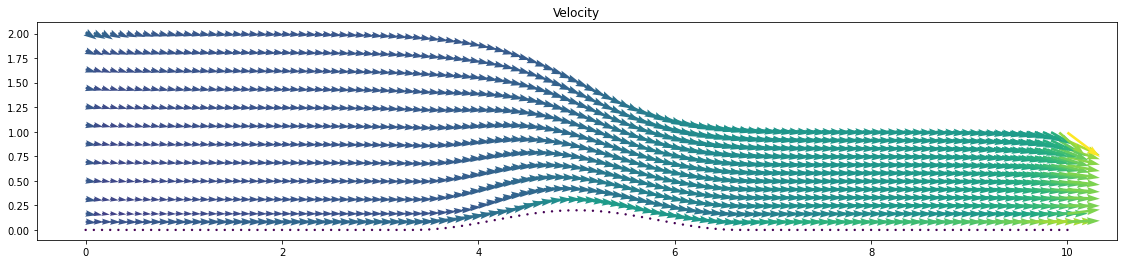

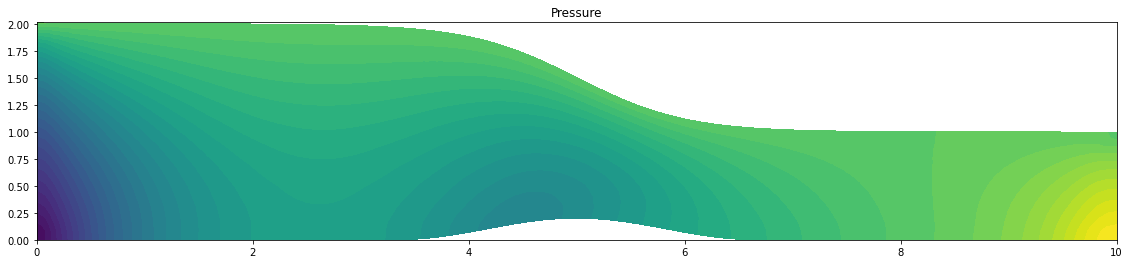

New Mesh:
Time t = 0.010178142795294706
2.0129322169758868 2.006084209454986 2.0052887248774716 2.0042701794971043 2.003655107857923 2.0031836246980164 2.0027894788633294 2.002457694093604 2.0021660476721492 2.001904233713452 2.001663354856225 2.0014373402239576 2.001221162347681 2.0010105906904863 2.000801766451926 2.0005909871530565 2.0003745232958092 2.00014847342661 1.9999086330736164 1.9996503665736345 1.9993684738895843 1.9990570465163264 1.9987093083518839 1.9983174367149488 1.9978723570820844 1.997363506423025 1.9967785602964792 1.9961031175713686 1.9953203363548082 1.9944105135979306 1.9933506022506011 1.992113658164517 1.9906682092780694 1.9889775401080925 1.9869988642732475 1.9846829731055406 1.9819726700527676 1.9788012840245912 1.9750925803462627 1.9707581046372507 1.9656976332902205 1.9597975925440791 1.9529303073595088 1.944953600332572 1.9357109335127123 1.9250324344253669 1.9127369880864387 1.89863581451819 1.8825378787669669 1.8642730287669418 1.8436646655755453 1.820

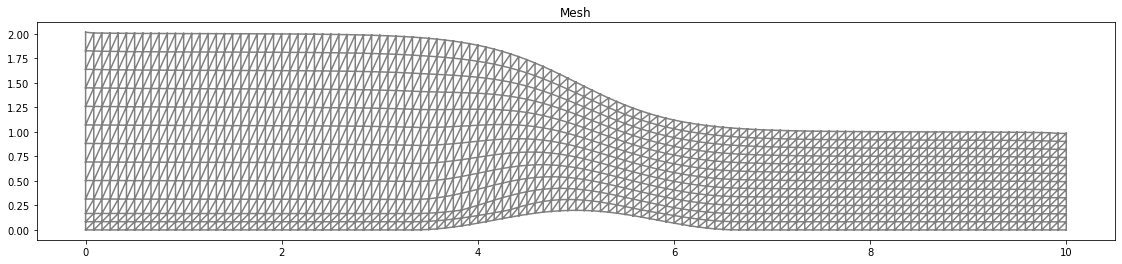

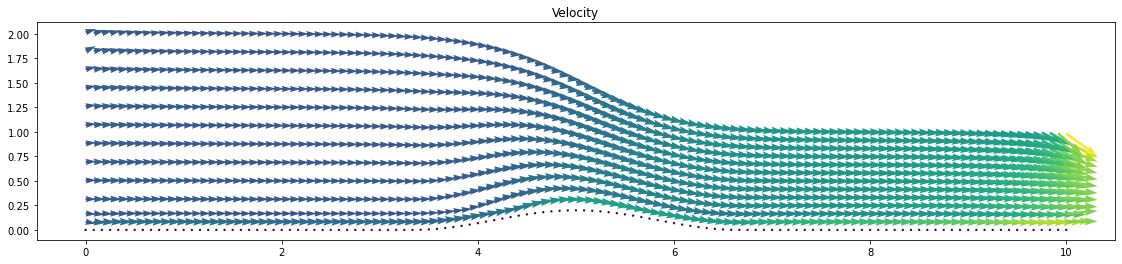

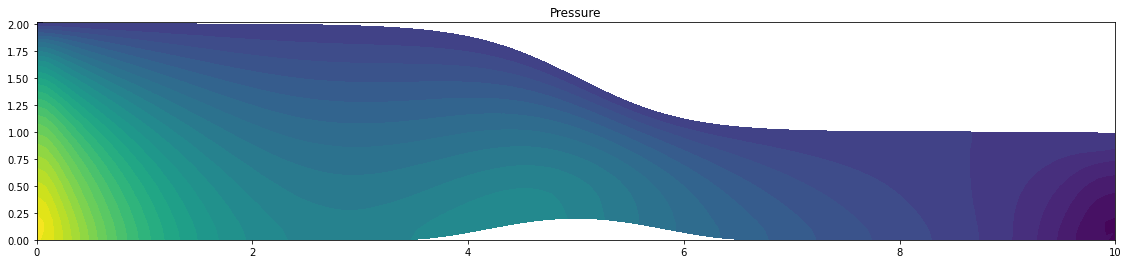

New Mesh:
Time t = 0.012722678494118383
2.0137535847160914 2.0072548045038063 2.006319123269851 2.005239111671278 2.004495157439376 2.003940549671025 2.003464379271397 2.0030613214720856 2.002707590374237 2.0023918161894763 2.002103800700941 2.0018363013119296 2.0015833623957584 2.001339994024683 2.001101736064431 2.0008644020756248 2.0006238730783905 2.0003759314538514 2.0001161152310227 1.9998395793340025 1.9995409536454969 1.9992141919578141 1.9988524088444661 1.998447697529164 1.997990922178447 1.997471480225498 1.9968770292448494 1.9961931720024326 1.9954030933020905 1.994487141422606 1.993422348296509 1.9921818800330027 1.9907344104413107 1.9890434118155558 1.9870663214615687 1.984754208953331 1.9820502444644403 1.9788881862568477 1.975192323792726 1.9708748255817112 1.965836169971466 1.9599636176067303 1.953130491597708 1.9451957434851592 1.9360040394288316 1.9253867725293747 1.9131640969848893 1.8991484180276716 1.8831493100102488 1.8649972081912067 1.8445154821566028 1.8215747

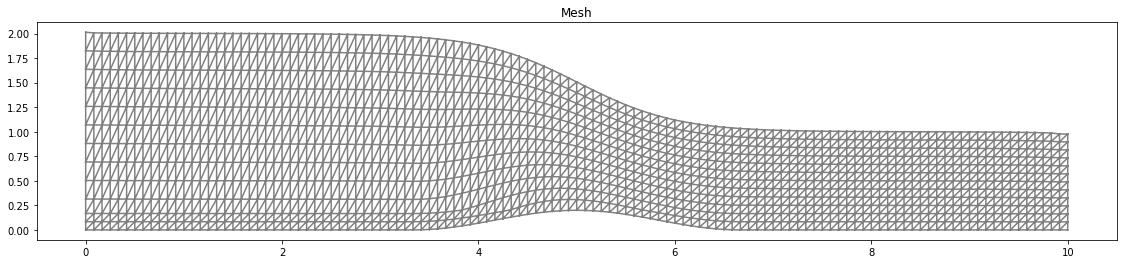

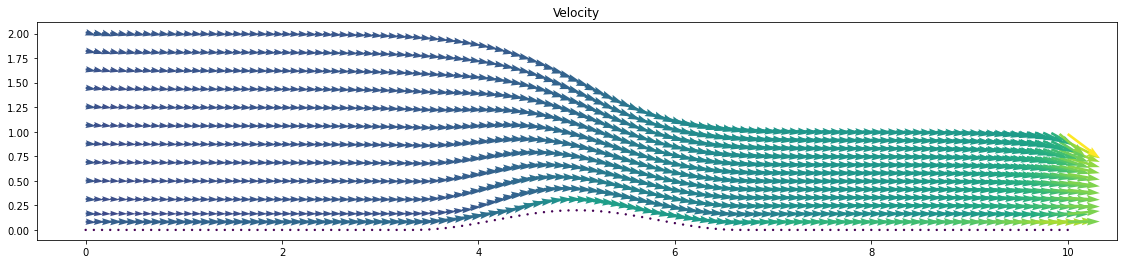

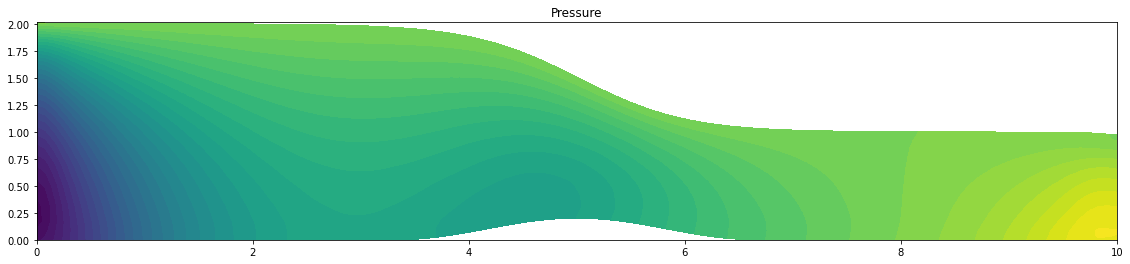

New Mesh:
Time t = 0.01526721419294206
2.012334696798087 2.006705039529216 2.0052724797910333 2.0044314701921917 2.0036998317952035 2.003218089090364 2.0027918701132505 2.002432129297229 2.0021157638064473 2.001833080813027 2.0015746079912495 2.001333543884095 2.0011043059314915 2.0008821973979503 2.000663017694205 2.0004428016953626 2.000217623413674 1.9999834345997565 1.9997359224021807 1.9994703733306562 1.999181535534144 1.9988634716209683 1.9985093982767228 1.9981115065580468 1.997660757126787 1.9971466456941365 1.9965569322640457 1.9958773289142266 1.9950911401131481 1.9941788473628075 1.9931176327238374 1.9918808326434045 1.990437315390978 1.988750776001537 1.986778893027267 1.9844730107330164 1.9817766333569908 1.9786238733184887 1.9749394139216256 1.9706358398622528 1.9656140233379005 1.959761601940417 1.9529522248895312 1.9450450706372957 1.9358848865333413 1.9253029699909212 1.913121245609044 1.8991601399174616 1.883224028947761 1.865151383737735 1.8447583787469346 1.8219145

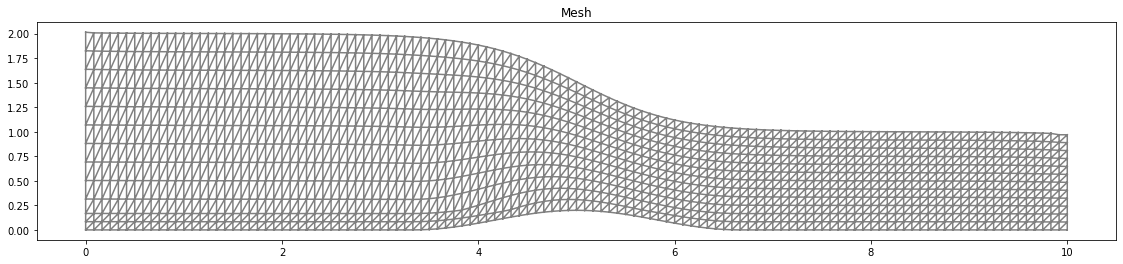

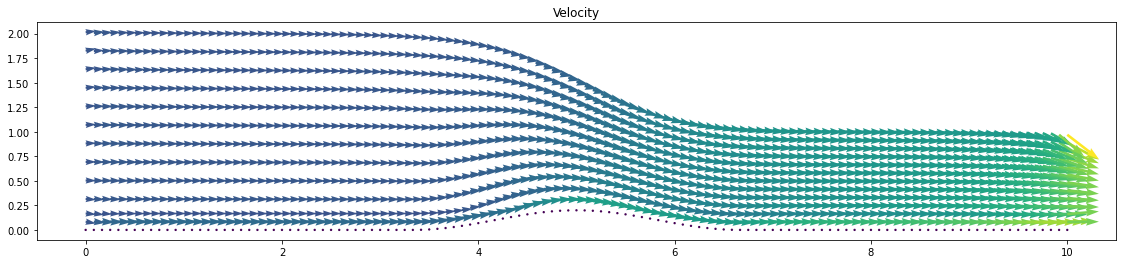

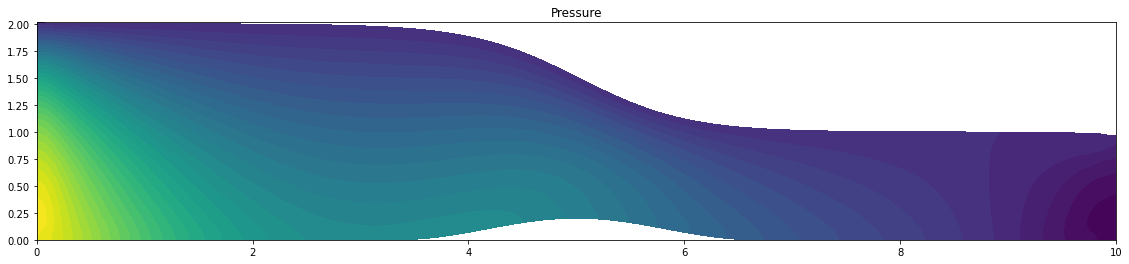

New Mesh:
Time t = 0.017811749891765736
2.0124984849610223 2.007250793600013 2.00561503914466 2.004832608921559 2.0040349947585527 2.0035204878245017 2.003061205405628 2.0026695962742465 2.002324223735803 2.002015453881481 2.0017338780730882 2.0014722473088646 2.001224635499902 2.0009860044609957 2.0007518753807907 2.0005180502485054 2.0002804115792743 2.0000347529344764 1.999776631548283 1.9995012281002338 1.999203205498123 1.998876559052349 1.9985144672919295 1.9981091029675628 1.9976513981987276 1.9971308621385544 1.996535246242843 1.9958502933408109 1.9950593565663373 1.9941429855545305 1.993078452507403 1.9918392083982508 1.9903942626032705 1.9887074820433912 1.9867367372493745 1.984433594885695 1.981741840125106 1.978595885481294 1.9749207494591179 1.9706301226707985 1.9656254859058646 1.9597955361038981 1.9530149115285433 1.9451435341642602 1.936027294325799 1.9254986450634983 1.9133805077372892 1.899494543365256 1.8836456556596577 1.8656728349307419 1.845392369880082 1.82267290

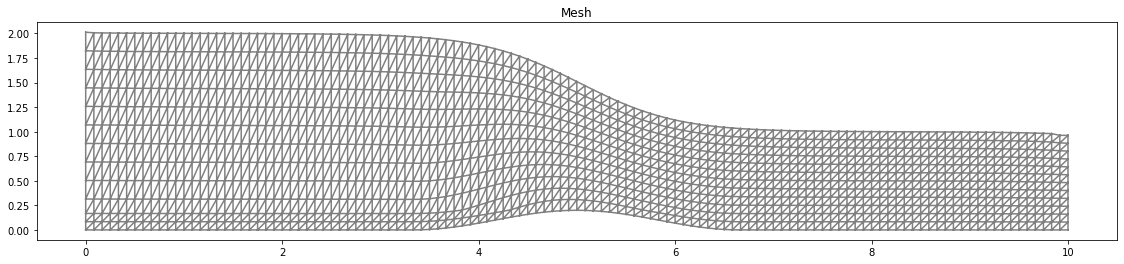

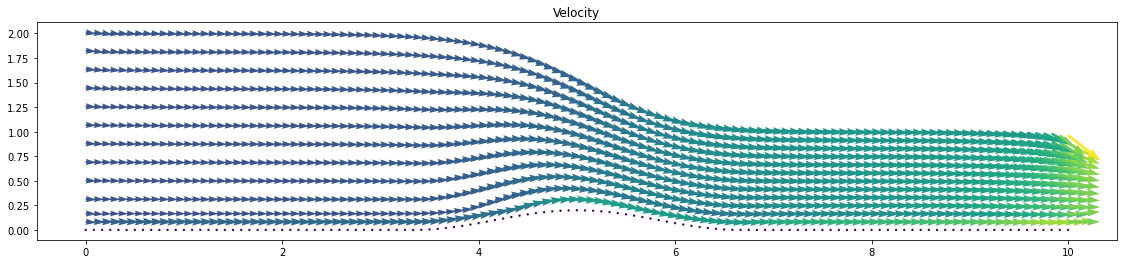

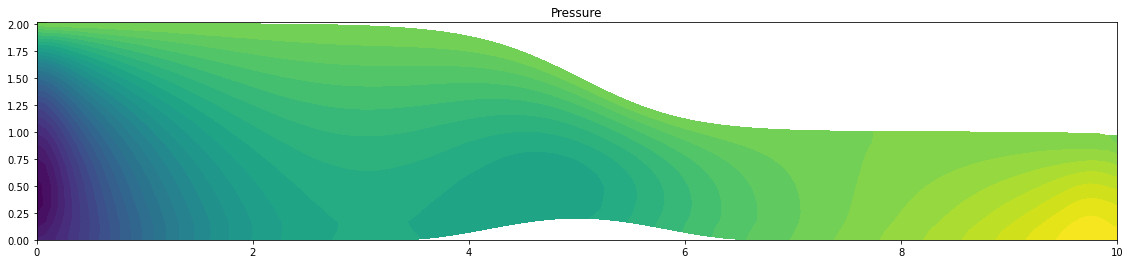

New Mesh:
Time t = 0.020356285590589412
2.0116052522995074 2.0070334537444703 2.0049978912838284 2.004388251163594 2.0035855720221076 2.0031021141849776 2.0026677808070867 2.0022960457831704 2.00196748268111 2.0016732193028166 2.0014046556717493 2.0011547263293976 2.000917656465179 2.0006884894278327 2.0004628208917055 2.0002365195495306 2.000005531975353 1.9997657137022804 1.9995126811792252 1.9992416714210814 1.9989474021069973 1.9986239227442042 1.9982644667838119 1.9978612647225436 1.997405309419707 1.9968861767992852 1.996291692707231 1.9956076831004264 1.994817597100055 1.9939020957371563 1.9928385811245015 1.9916006554689285 1.9901575045574367 1.98847320192804 1.9865058447220478 1.9842072584331587 1.9815215485981301 1.9783834712763455 1.9747184122002113 1.9704404694907178 1.9654515195083828 1.9596406318498598 1.9528827952916048 1.9450381838292796 1.9359527924214501 1.9254606324790318 1.9133910049793443 1.899562475641409 1.883786404593688 1.8658969985474223 1.8457105235170628 1.8

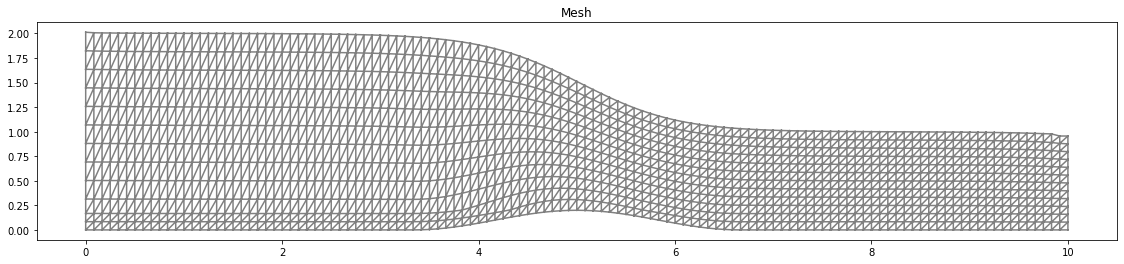

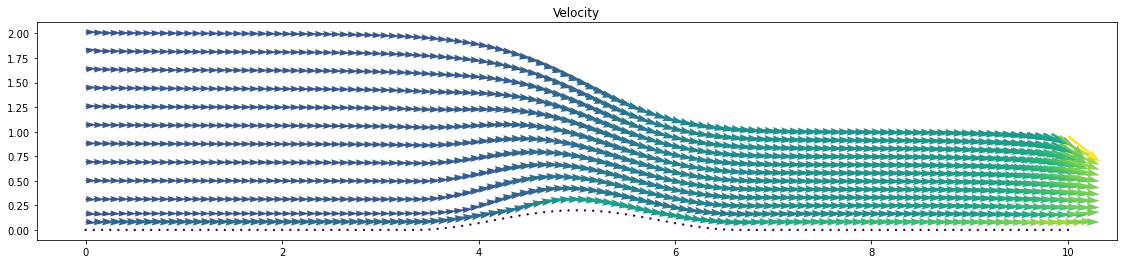

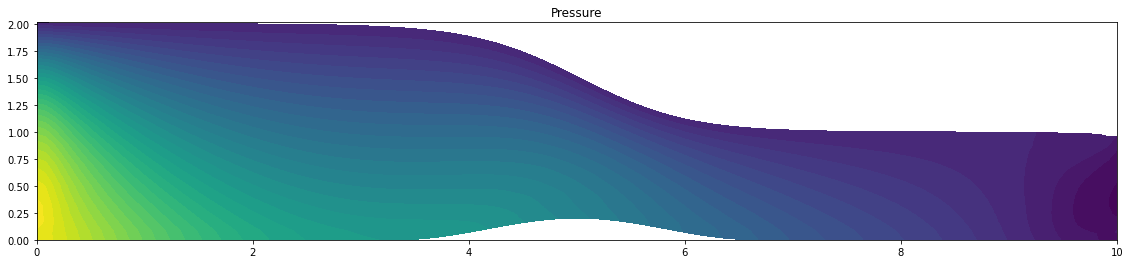

New Mesh:
Time t = 0.02290082128941309
2.011475723528351 2.0073161183980526 2.0050236460544646 2.0045014427224426 2.0036700668211838 2.0031704121670626 2.0027248292747997 2.002339845712874 2.0019987035101026 2.0016923505388178 2.00141280833348 2.0011529642152337 2.0009069302908475 2.0006696181230863 2.00043646659152 2.0002032295261087 1.9999657578453665 1.9997198289464224 1.9994609964588088 1.999184447984973 1.998884863870841 1.9985562671481691 1.9981918755302408 1.9977839154906418 1.9973233862749191 1.996799882379995 1.996201261365707 1.9955133943258767 1.9947197920121988 1.9938011953392725 1.9927351074087185 1.9914952549521976 1.990050974754146 1.9883665230936507 1.9864002011023854 1.984104068808226 1.9814225278272946 1.9782906550625508 1.9746341788567072 1.9703675809634724 1.9653931099912514 1.9596001877939198 1.9528654822458384 1.945051313528332 1.9360041933592465 1.9255605070250088 1.9135490934210784 1.8997897434628845 1.8840943829618184 1.8662978920023023 1.846216657399629 1.8237

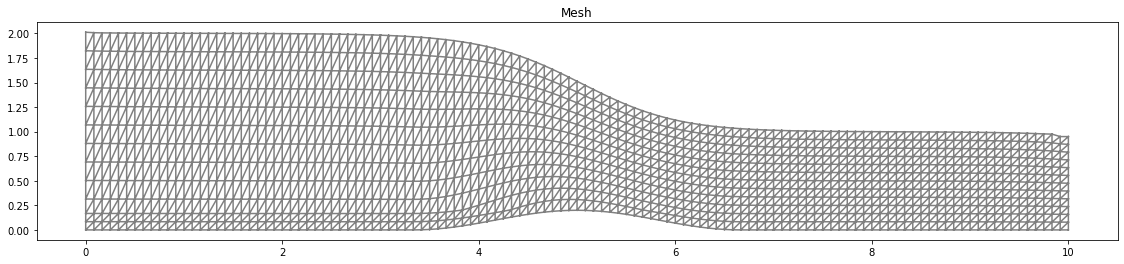

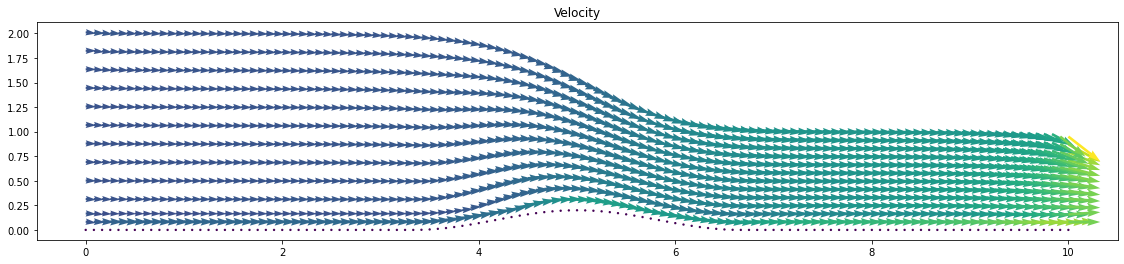

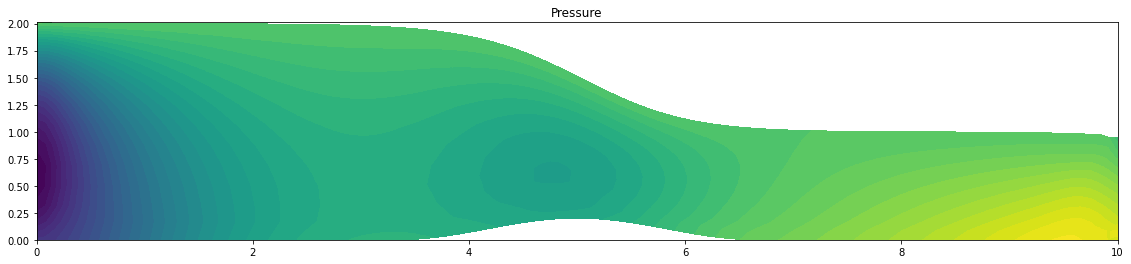

New Mesh:
Time t = 0.025445356988236766
2.010846790559826 2.007248899028103 2.004603179132742 2.0042105021826964 2.003380835763381 2.0028911223855217 2.00246007844593 2.0020852630494788 2.001752624229473 2.001453036711081 2.0011793291320874 2.000924625943982 2.000683158526278 2.0004498798283685 2.0002202468991803 1.9999900264328383 1.9997550840977334 1.9995112153431367 1.9992539946640553 1.9989786329265615 1.9986798364829073 1.9983516572950908 1.9979873456636819 1.9975791661381326 1.9971181611715905 1.996593976144964 1.995994528700062 1.9953057600974322 1.994511265077547 1.9935918846897647 1.9925252414762713 1.9912852038216537 1.9898412760019695 1.9881579134697591 1.9861936381146665 1.9839007620264844 1.9812240023635144 1.978098779506224 1.974451189959588 1.9701961290296692 1.9652362545423987 1.959461349533757 1.952748416861015 1.944960099499992 1.935943033730371 1.9255372827691979 1.913574021691091 1.8998742378348805 1.8842522223512406 1.8665403705718968 1.8465551665166753 1.824162609

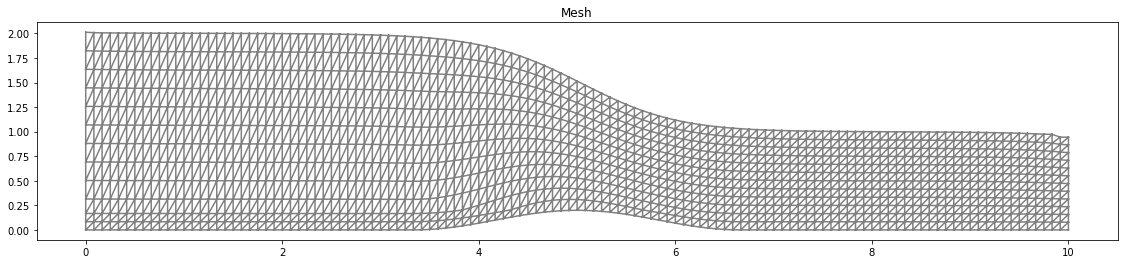

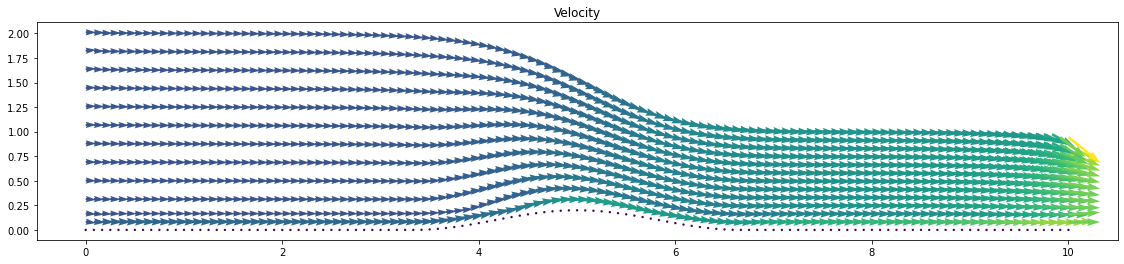

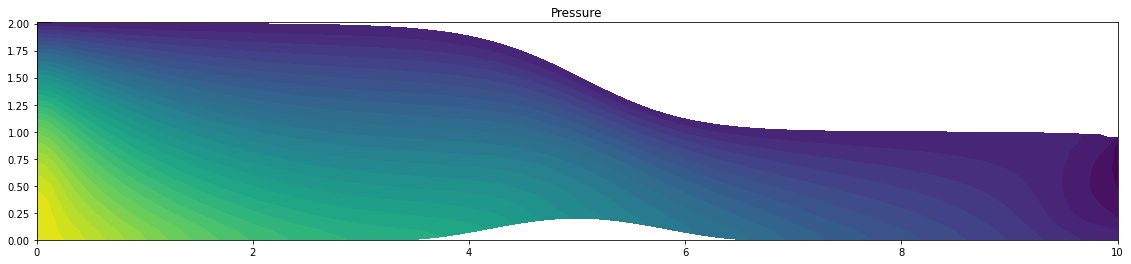

New Mesh:
Time t = 0.027989892687060442
2.0106020833038074 2.00742252063357 2.0044934165187303 2.0041808701010653 2.0033486793085378 2.0028463679756014 2.0024131779021883 2.0020331984230824 2.0016955746533815 2.0013905501432965 2.0011115619153372 2.0008518931837385 2.000605808422181 2.000368220699731 2.00013452228525 1.9999004157922071 1.9996617114684745 1.9994141599338613 1.9991533009071119 1.9988743195944445 1.9985719051963557 1.9982401004380161 1.9978721544274962 1.9974603399788364 1.9969957163541867 1.9964679562035244 1.995865016209145 1.995172888959482 1.9943752360663036 1.9934529829743126 1.992383857202877 1.9911418555130846 1.9896966370854656 1.9880128449910917 1.986049211405828 1.983758288978345 1.9810850992908717 1.977965397228002 1.9743256378064233 1.9700811214694884 1.965134910567473 1.9593771480681892 1.9526851768309363 1.944921989895574 1.9359394128776604 1.9255753805488556 1.9136663305672645 1.9000318564680814 1.884486505020192 1.8668634648666163 1.8469794100400407 1.8246

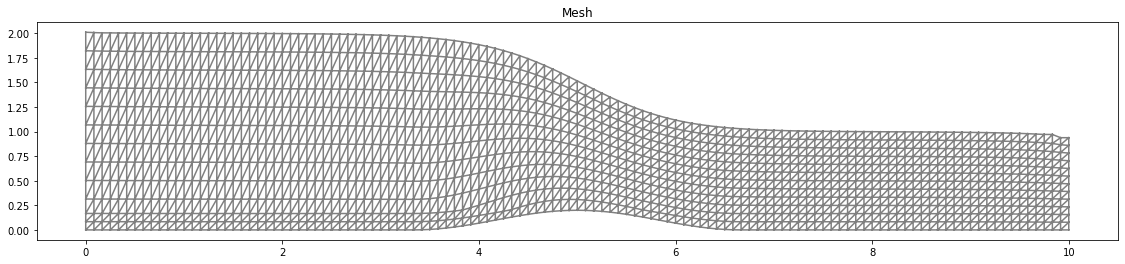

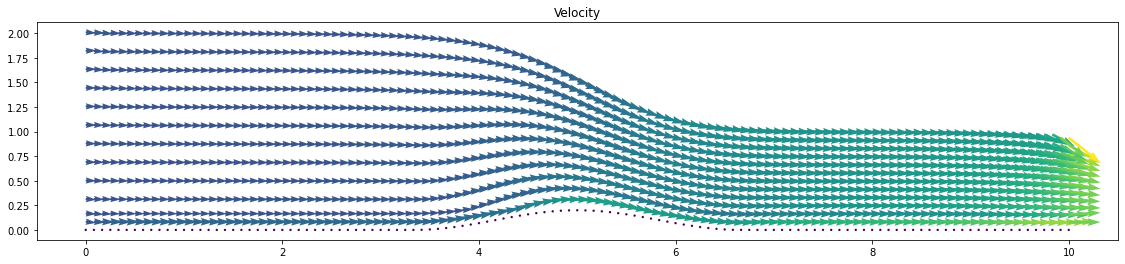

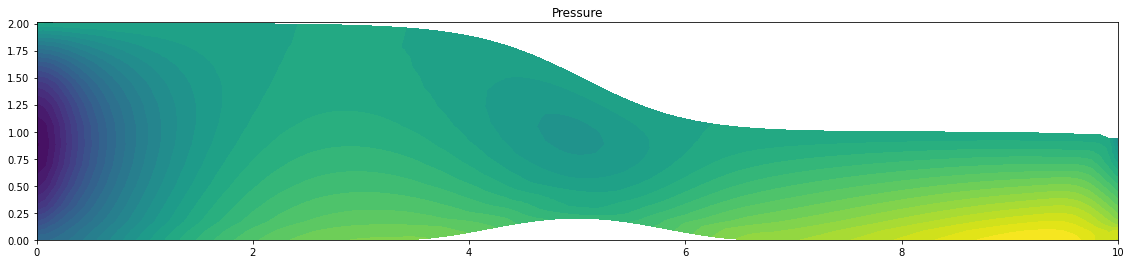

New Mesh:
Time t = 0.03053442838588412
2.010122159183515 2.0074298017562193 2.0041759251857854 2.0039525393726487 2.003137152486321 2.0026329944163646 2.002209150339556 2.001834685019353 2.001501814713498 2.0012001962758297 2.0009238242264273 2.000666269617323 2.000421927239294 2.000185763771817 1.9999531794446421 1.9997198728641117 1.9994816495761536 1.9992342591789078 1.9989732446116144 1.998693798544657 1.998390622067072 1.9980577741514516 1.9976885250212968 1.9972751752601412 1.9968088179585048 1.9962791679658747 1.9956742341187106 1.994980071750926 1.9941804193917114 1.993256296073819 1.9921855427140553 1.9909422921183884 1.9894963658261309 1.9878126022924547 1.9858499522209332 1.9835612173168575 1.9808917335070506 1.9777776029583474 1.9741456539576412 1.9699116102593386 1.9649789620521554 1.9592382363040068 1.9525671455259104 1.944828940024926 1.9358756056442536 1.9255479153375235 1.9136860432024323 1.9001095820618665 1.8846368791468888 1.867098238078596 1.847310552693921 1.82513

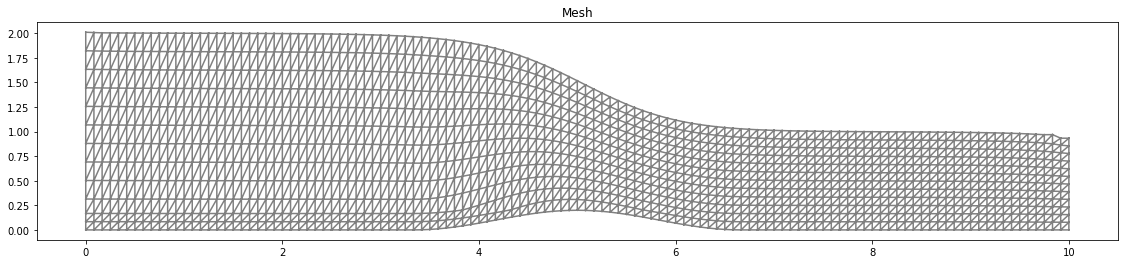

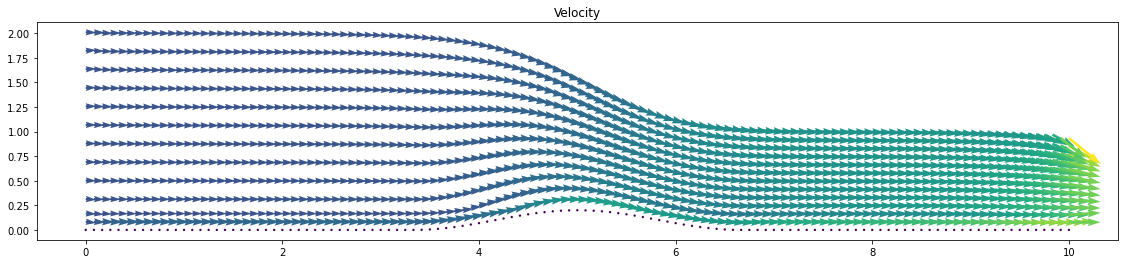

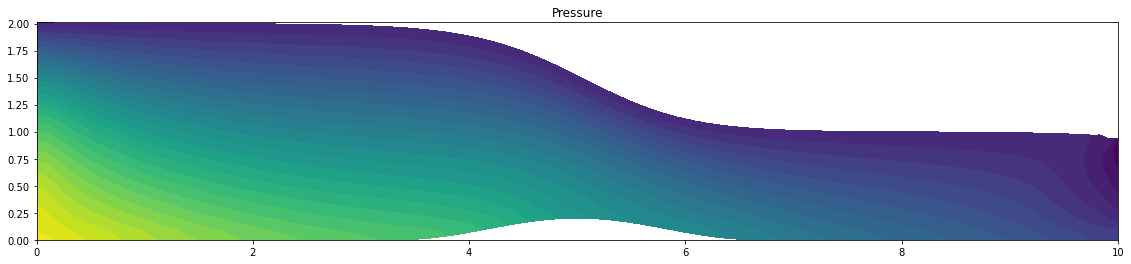

New Mesh:
Time t = 0.0330789640847078
2.0098432435846934 2.007555764916998 2.004015912713713 2.0038459472119126 2.003050761831826 2.0025336534430207 2.0021110318787314 2.0017347325481656 2.0014001925778477 2.001096267160787 2.000817293429057 2.000557077554341 2.0003101057464594 2.00007137076322 1.9998362500502125 1.9996004064788762 1.9993596101091076 1.9991095808222754 1.9988458388224004 1.9985635610848997 1.9982574399166673 1.9979215321017856 1.997549112468913 1.9971324946616058 1.9966627924854832 1.9961297510860045 1.9955214207365142 1.9948239099243337 1.9940210253110846 1.9930938712499862 1.9920203944027568 1.9907748567219365 1.989327235562734 1.9876425589236557 1.9856799912021676 1.9833925776448191 1.9807259634065106 1.9776165952016607 1.9739916720039992 1.9697673399278421 1.964847520450508 1.959123130722337 1.9524722655943856 1.9447584607541133 1.9358338347591395 1.9255458001502423 1.9137311661528449 1.9002168168293998 1.8848178263478024 1.8673651502068598 1.8476759478387885 1.825

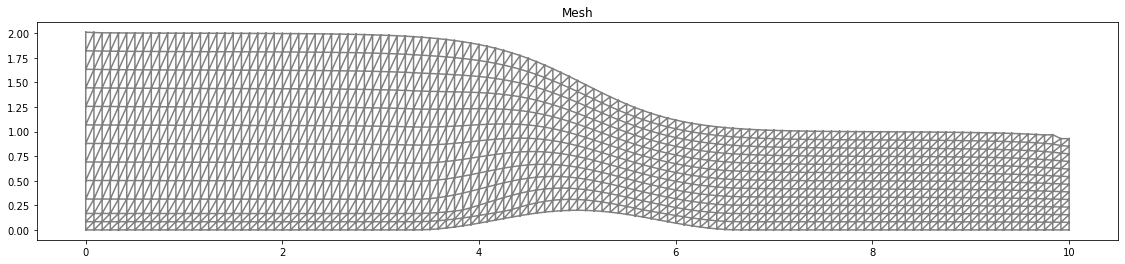

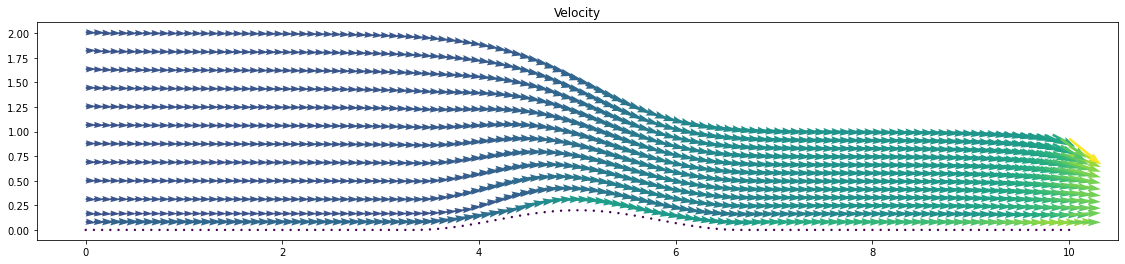

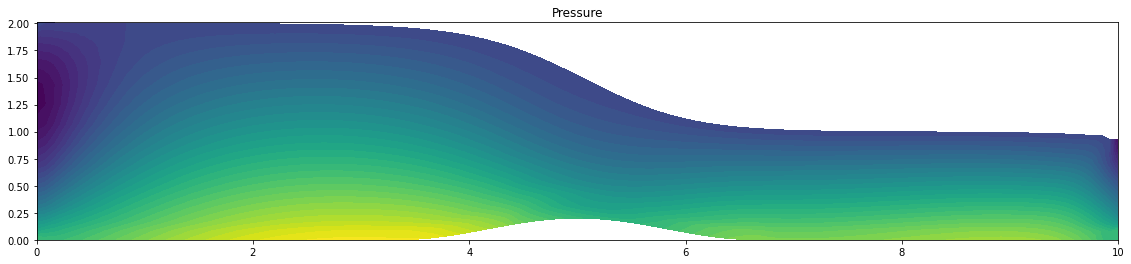

New Mesh:
Time t = 0.03562349978353148
2.0094571954868785 2.007601979728796 2.0037625780025135 2.003638355972506 2.002877077913388 2.002351739099474 2.0019354415262303 2.0015622587014423 2.0012305564124677 2.0009285230594833 2.000650713909738 2.0003912073317798 2.0001446194595793 1.9999060169943024 1.9996707943718812 1.9994346097336413 1.9991932226524702 1.9989423441112093 1.998677489155248 1.9983938341811216 1.9980860759133323 1.997748280493134 1.9973737374326752 1.9969547822297808 1.9964825570159475 1.995946843863773 1.995335740273112 1.9946354127678938 1.9938297403080116 1.992899916453522 1.9918239971694138 1.990576376670046 1.989127191205252 1.9874416618594868 1.9854791708455215 1.9831930110670197 1.9805291420548838 1.977424362870516 1.9738062524730455 1.9695913914527376 1.9646841496183975 1.9589758524062575 1.952344995612448 1.944655437762417 1.9357592988576138 1.9255045778332587 1.913735910492611 1.9002761377707886 1.8849484119013749 1.8675791143983165 1.8479857044293009 1.826031

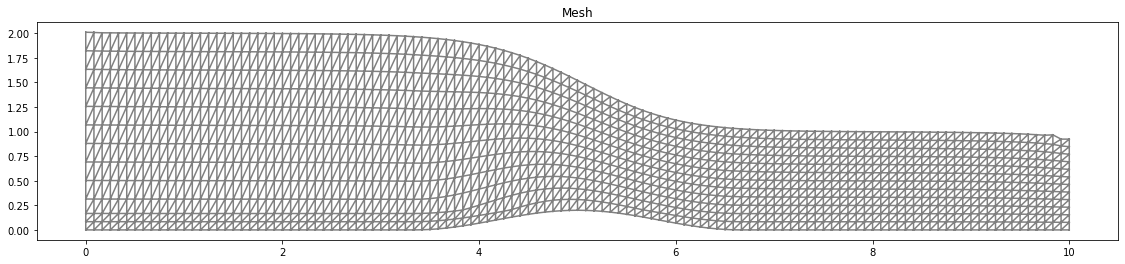

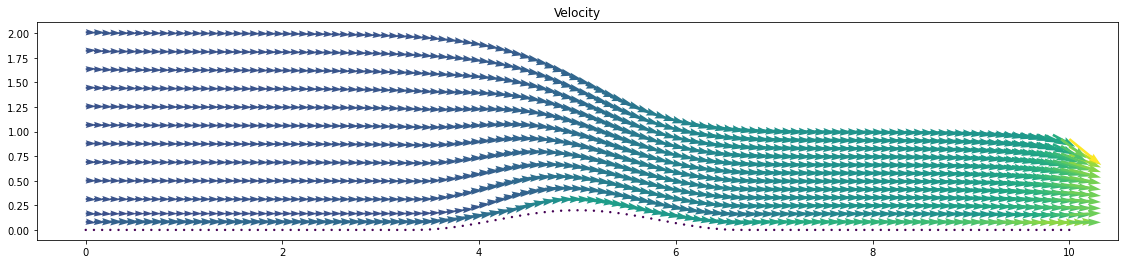

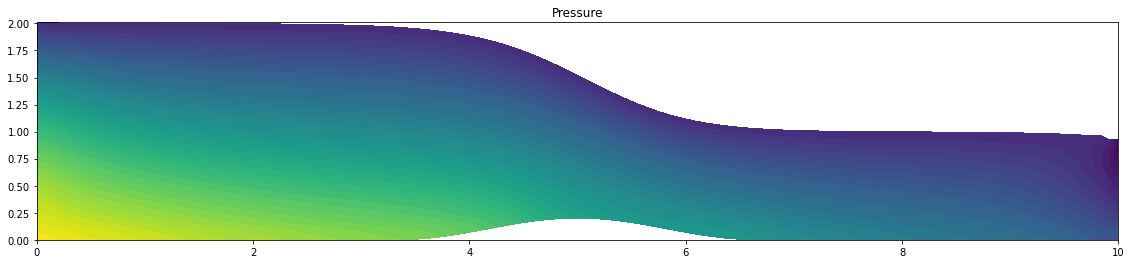

New Mesh:


KeyboardInterrupt: ignored

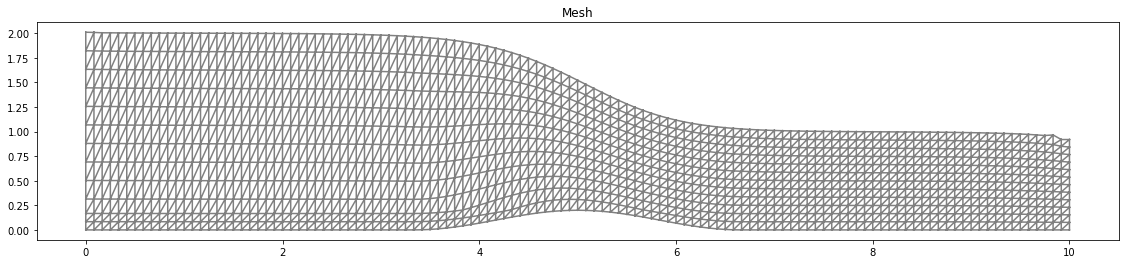

In [39]:
!rm results-NS/*

# apply initial conditions
#p0.interpolate(p_init)
#p1.interpolate(p_init)
# ^ does this even do anything?
if not closed:
    u0.interpolate(u_init)
    u1.interpolate(u_init)

print("Initial Pressure")
plt.figure(figsize=(40, 4))
plot(p1, title="Pressure")
print("===========")

print("Initial Velocity")
plt.figure(figsize=(40, 4))
plot(u1, title="Velocity")
print("===========")


# Time stepping
T = 5
t = dt

def surface_node_compare(surface_node):
    return surface_node.position[0]

class SurfaceNode():
    def __init__(self, mesh_index, position, u):
        self.mesh_index = mesh_index
        self.position = position
        self.velocity = u(position[0], position[1])

    def setup(self, surface):
        if self.index == 0:
            self.k = (self.position[1] - surface[1].position[1])/delta_x
        elif self.index == len(surface) - 1:
            self.k = (surface[-2].position[1] - self.position[1])/delta_x
        else:
            self.k = (surface[self.index + 1].position[1] - surface[self.index - 1].position[1])/(2*delta_x)

        self.k_scale = 1/sqrt(1 + self.k**2)
        self.delta_s = delta_x/self.k_scale
        self.n = [-self.k*self.k_scale, self.k_scale]
        self.Vdot = (self.n[0]*self.velocity[0] + self.n[1]*self.velocity[1])*self.delta_s*dt
        self.Vxdot = self.n[0]*self.Vdot
        self.Vydot = self.n[1]*self.Vdot
        self.W = self.Vydot/delta_x
        self.Wp = max(0, self.Vxdot/delta_x)
        self.Wm = max(0, -self.Vxdot/delta_x)

    def timestep(self, surface, boundary_coordinates):
        x = boundary_coordinates[self.mesh_index]
        x[1] += self.W
        if self.index != 0:
            x[1] += surface[self.index - 1].Wp
        elif closed:
            x[1] += self.Wm
        if self.index != len(surface) - 1:
            x[1] += surface[self.index + 1].Wm
        elif closed:
            x[1] += self.Wp
        else: # this builds on increasing update order
            x[1] = surface[self.index - 1].position[1]
        self.position = x

while t < T + DOLFIN_EPS:
    # extract the boundary mesh for the surface
    boundary = BoundaryMesh(mesh, "exterior", True)

    surface_nodes = []
    left_node_indices = []   # not including top
    right_node_indices = []  # not including top
    left_max = 0
    left_max_index = -1
    right_max = 0
    right_max_index = -1
    for i, x in enumerate(boundary.coordinates()):
        if lower.inside(x, True):
            pass
        elif left.inside(x, True):
            left_node_indices.append(i)
            if x[1] > left_max:
                left_max = x[1]
                left_max_index = i
        elif right.inside(x, True):
            right_node_indices.append(i)
            if x[1] > right_max:
                right_max = x[1]
                right_max_index = i
        else:
            surface_nodes.append(SurfaceNode(i, x, u1))
    surface_nodes.insert(0, SurfaceNode(left_max_index, [0.0, left_max], u1))
    surface_nodes.append(SurfaceNode(right_max_index, [L, right_max], u1))
    left_node_indices.remove(left_max_index)
    right_node_indices.remove(right_max_index)

    surface_nodes.sort(key=surface_node_compare)

    # displace surface boundary
    for i, node in enumerate(surface_nodes):
        node.index = i
    for node in surface_nodes:
        node.setup(surface_nodes)
    for node in surface_nodes:
        node.timestep(surface_nodes, boundary.coordinates())

    # deform edge boundary
    new_y_left = boundary.coordinates()[left_max_index][1]
    for j, i in enumerate(left_node_indices):
        x = boundary.coordinates()[i]
        positional_scale = x[1]/left_max
        x[1] = new_y_left*positional_scale
    new_y_right = boundary.coordinates()[right_max_index][1]
    for j, i in enumerate(right_node_indices):
        x = boundary.coordinates()[i]
        positional_scale = x[1]/right_max
        x[1] = new_y_right*positional_scale

    # Solve non-linear problem 
    k = 0
    while k < num_nnlin_iter: 
        
        # Assemble momentum matrix and vector 
        Au = assemble(au)
        bu = assemble(Lu)

        # Compute velocity solution 
        [bc.apply(Au, bu) for bc in bcu]
        [bc.apply(u1.vector()) for bc in bcu]
        solve(Au, u1.vector(), bu, "bicgstab", "default")

        # Assemble continuity matrix and vector
        Ap = assemble(ap) 
        bp = assemble(Lp)

        # Compute pressure solution 
        [bc.apply(Ap, bp) for bc in bcp]
        [bc.apply(p1.vector()) for bc in bcp]
        solve(Ap, p1.vector(), bp, "bicgstab", prec)

        # Add time
        if (t > start_sample_time):
          time = np.append(time, t)

        k += 1

    #boundary2 = BoundaryMesh(mesh, "exterior", True)
    #for i, x in enumerate(boundary.coordinates()):
    #    print(str(i) + ": ", x, " -> ", u1(x))

    # Save solution to file at every time step
    file_u << u1
    file_p << p1

    # write at even seconds
    #if abs(t - round(t)) < dt and not near(t, 0.0) and not near(t, T):
    #    !tar -czvf results-NS.tar.gz results-NS
    #    files.download('results-NS.tar.gz')
    # this doesn't work

    if True or t > plot_time:     
        
        s = 'Time t = ' + repr(t) 
        print(s)

        # Plot solution
        plt.figure(figsize=(40, 4))
        plot(u1, title="Velocity")

        plt.figure(figsize=(40, 4))
        plot(p1, title="Pressure")

        for node in surface_nodes:
          print(str(node.position[1]) + " ", end="")
        print()
        
        plot_time += T/plot_freq
        
        plt.show()

    # reshape mesh
    w_new = ALE.move(mesh, boundary)
    w.set_md(w_new)
    #pout.h = right_max
    uout.h = right_max
    uin.h = left_max
    # this supposedly helps to avoid crashing at solve
    mesh.bounding_box_tree().build(mesh)

    # show reshaped mesh
    print("New Mesh:")
    plt.figure(figsize=(40, 4))
    plot(mesh, title="Mesh")

    # Update time step
    u0.assign(u1)
    t += dt

In [ ]:

!tar -czvf results-NS.tar.gz results-NS
files.download('results-NS.tar.gz')